In [1]:
library(openxlsx)
library(reshape)
library(tidyverse)

library(ggplot2)
library(RColorBrewer)
library(corrplot)

Warning message:
"程辑包'openxlsx'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'tidyverse'是用R版本4.1.3 来建造的"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.5.0
v readr   2.1.1     v forcats 0.5.1
Warning message:
"程辑包'ggplot2'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'stringr'是用R版本4.1.3 来建造的"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x tidyr::expand() masks reshape::expand()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::rename() masks reshape::rename()
corrplot 0.92 loaded



# Import data

In [2]:
# Organize relationship score
regions = c(
    # English
    'USA','UK','Australia','South Africa',
    # Germany
    'Germany',
    # Japanese
    'Japan',
    # Hebrew
    'Israel',
    # Chinese
    'CHN','HK(region)',

    # French
    'France',
    # Spanish
    'Spain','Mexico','Chile',
    # Portuguese
    'Portugal','Brazil',
    # Russian
    'Russia',
    # Arabic
    'Egypt','Qatar',
    'India')

In [3]:
file_path = 'output_data/cleaning_results/'
raw_data_list = list()
for (region in dir(file_path)){
    file = paste(file_path,region,sep='')
    file = paste(paste(file,'/',sep=''),region,sep='')
    file = paste(file,'_dim_rel.csv',sep='')
    raw_df = read.csv(file,row.names=1)
    raw_df = data.frame(t(raw_df))
    
    region = gsub('HK','HK(region)',region) 
    region = gsub('South_africa','South Africa',region)
    
    # The dimension should be reversed due to the questionnair set
    if (region %in% c('Chile','Mexico','Spain')){
        raw_df['Goods.Exchange'] = 100-raw_df['Goods.Exchange']}
    if (region %in% c('Israel')){
        raw_df['Socioemotional'] = 100-raw_df['Socioemotional']
        raw_df['Synchronicity'] = 100-raw_df['Synchronicity']}
    if (region %in% c('Brazil','Portugal','Russia')){
        raw_df['Morality'] = 100-raw_df['Morality']}
    if (region %in% c('France')){
        raw_df['Formality.and.Regulation'] = 100-raw_df['Formality.and.Regulation']
        raw_df['Expected.Reciprocity'] = 100-raw_df['Expected.Reciprocity']
        raw_df['Information.Exchange'] = 100-raw_df['Information.Exchange']
        raw_df['Money.Exchange'] = 100-raw_df['Money.Exchange']
        raw_df['Mating'] = 100-raw_df['Mating']
        raw_df['Importance.for.society'] = 100-raw_df['Importance.for.society']
        raw_df['Importance.for.individuals'] = 100-raw_df['Importance.for.individuals']
        raw_df['Occupational'] = 100-raw_df['Occupational']}

    raw_data_list[[region]] = raw_df}

# Averaged world model(leave one out)

In [4]:
averaged_world_loocv = function(region){
    regions_left = regions[-which(regions==region)]
    raw_region_left = raw_data_list[[regions_left[1]]] + raw_data_list[[regions_left[2]]]
    for (temp_region in regions_left[2:18]){
        raw_region_left = raw_region_left + raw_data_list[[temp_region]]
    }
    raw_region_left = raw_region_left/18
    write.csv(raw_region_left,
              paste('input_data/Nations/Total/averaged_world_loocv_raw/',region,'.csv',sep=''))
    
    dim_rel_scaled = scale(raw_region_left)
    dim_rel.pca = prcomp(dim_rel_scaled)
    ncomp = 5

    loadings_none = dim_rel.pca$rotation[,1:ncomp]
    scores_none = dim_rel.pca$x[,1:ncomp] 

    rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
    loadings_var = varimax(rawLoadings)$loadings
    scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat
    scores_var = as.data.frame(scores_var)
    write.csv(scores_var,
              paste('input_data/Nations/Total/averaged_world_loocv_favee/',region,'.csv',sep=''))
    
    loadings_var_reorder = as.data.frame(loadings_var[,1:5])
    colnames(loadings_var_reorder) = c('Activeness','Exchange','Formality','Equality','Valence')

    #filter each row's max loading, and attribute it to correspnding column.
    order_list = c()
    for (row in c(1:33)){
        temp_max = abs(loadings_var_reorder[row,1])
        n = 1
        for (col in c(2:5)){
            temp = abs(loadings_var_reorder[row,col])
            if (temp > temp_max){
                temp_max = temp
                n = col
            }

        }
        order_list[row] = n
    }
    loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
    loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
    RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
    RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
    RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Valence))
    RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Exchange))
    RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))
    rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

    loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
    loadings_var_reorder = loadings_var_reorder[1:5]

    options(repr.plot.width=6, repr.plot.height=10)
    my.breaks = c(seq(-1,1,by=0.01))
    corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
             tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
             col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
             col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)),
             title=region,mar=c(0, 0, 1, 0))
}

## plot loadings

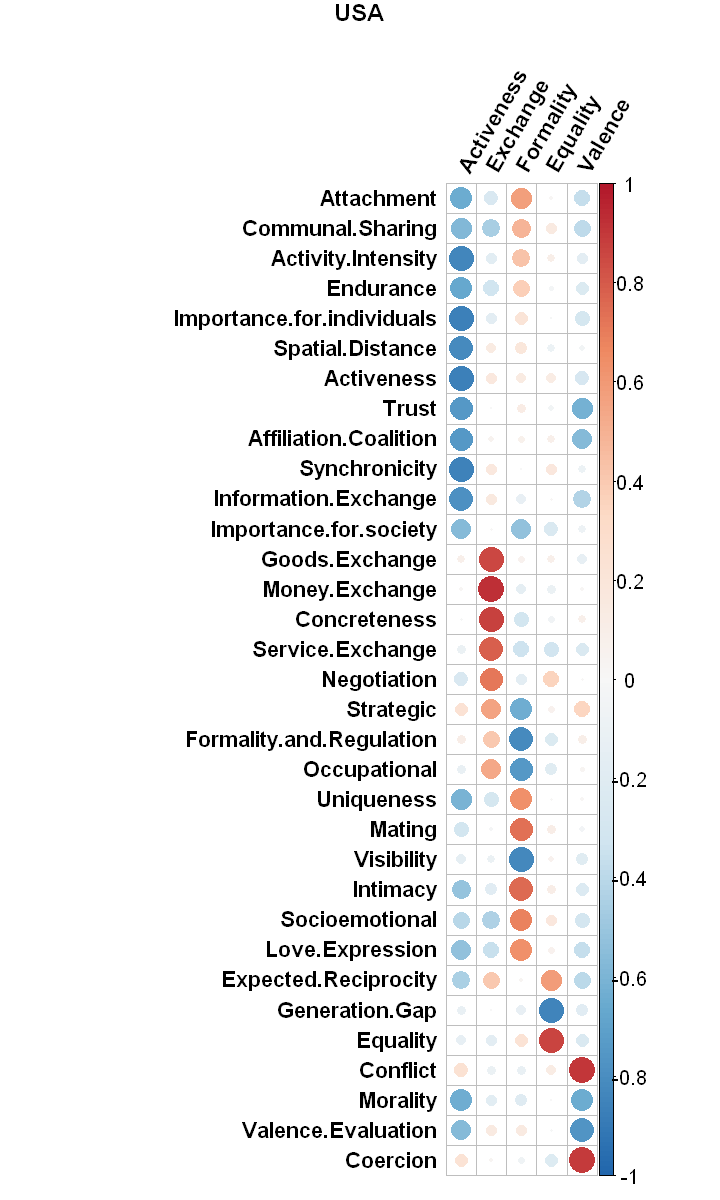

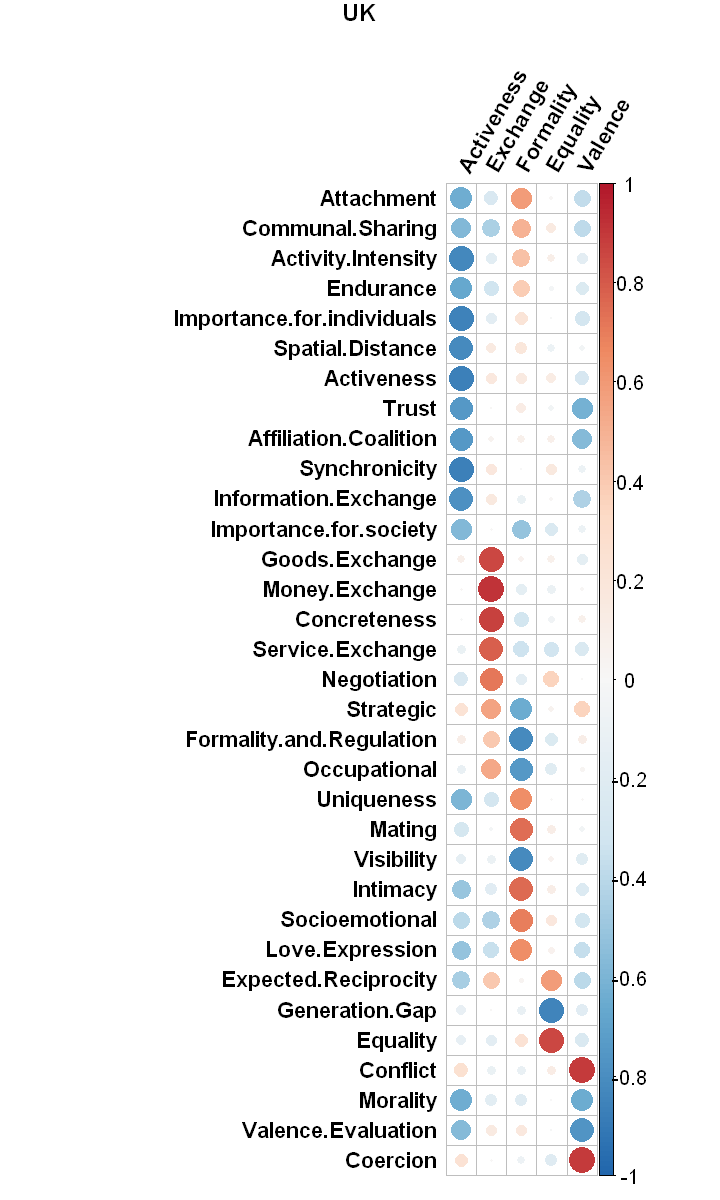

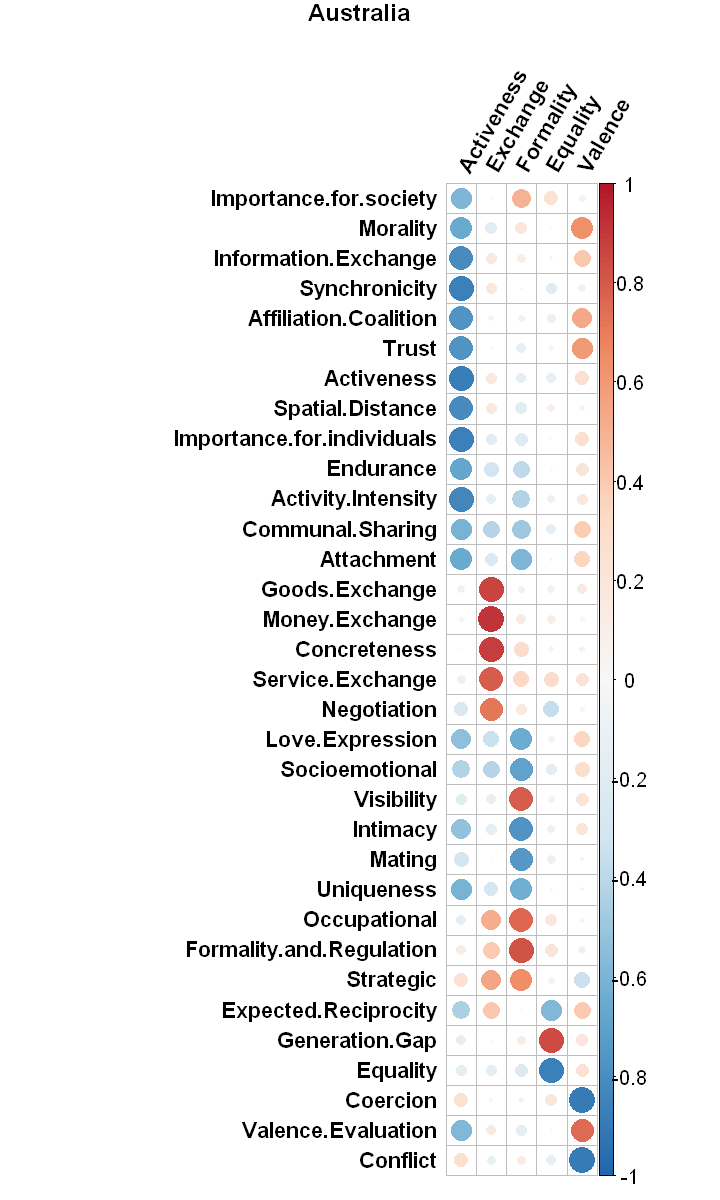

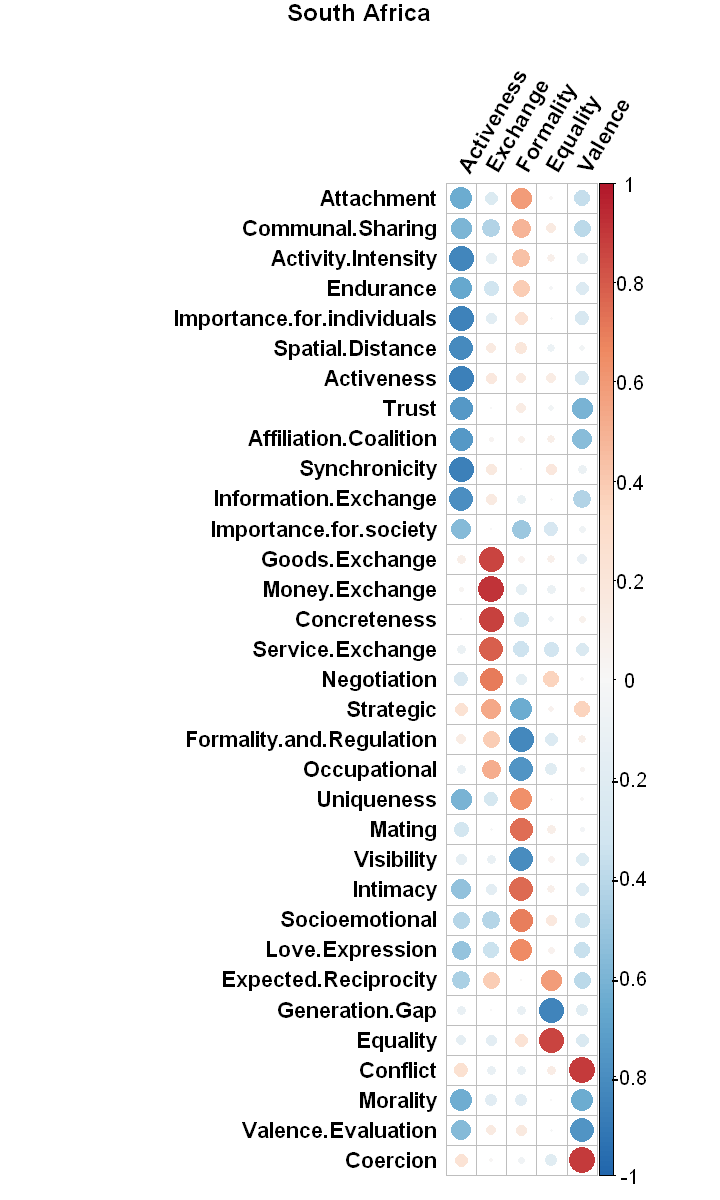

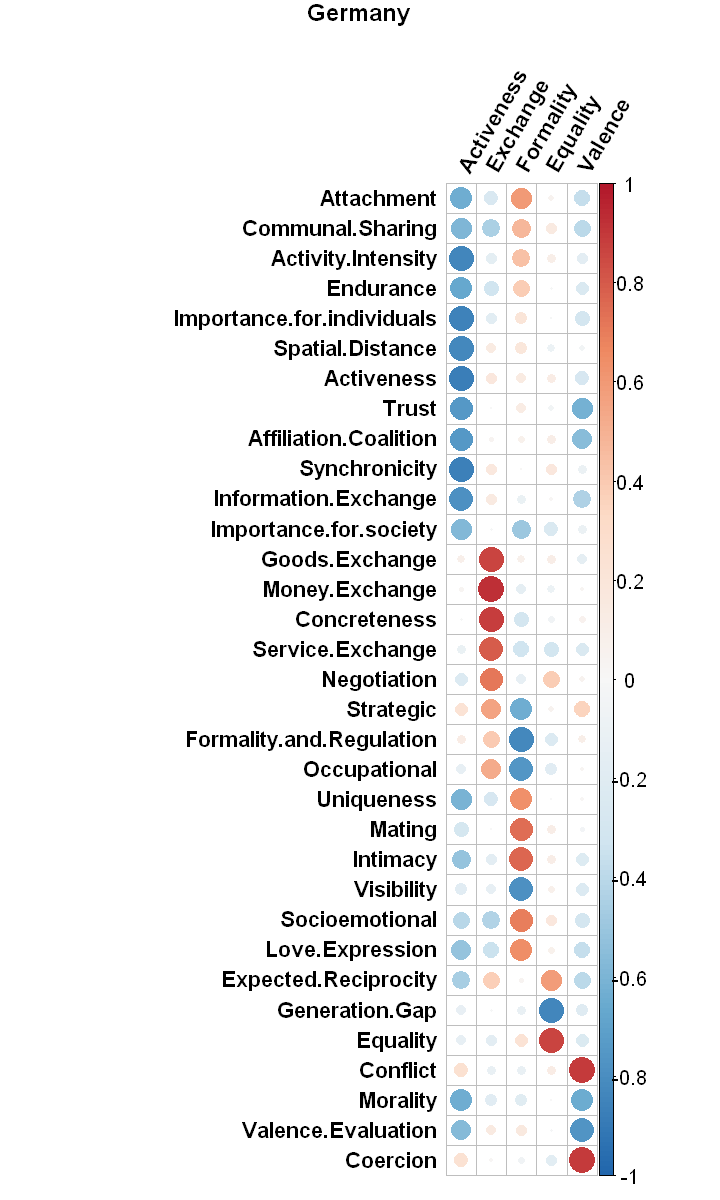

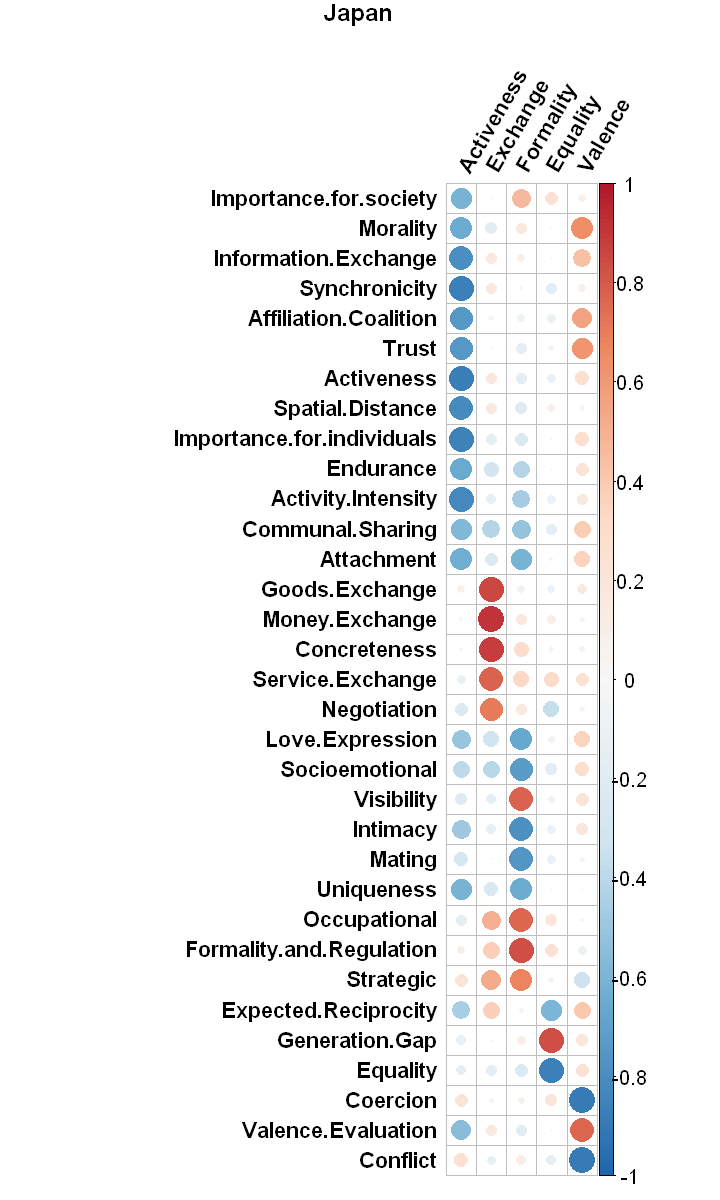

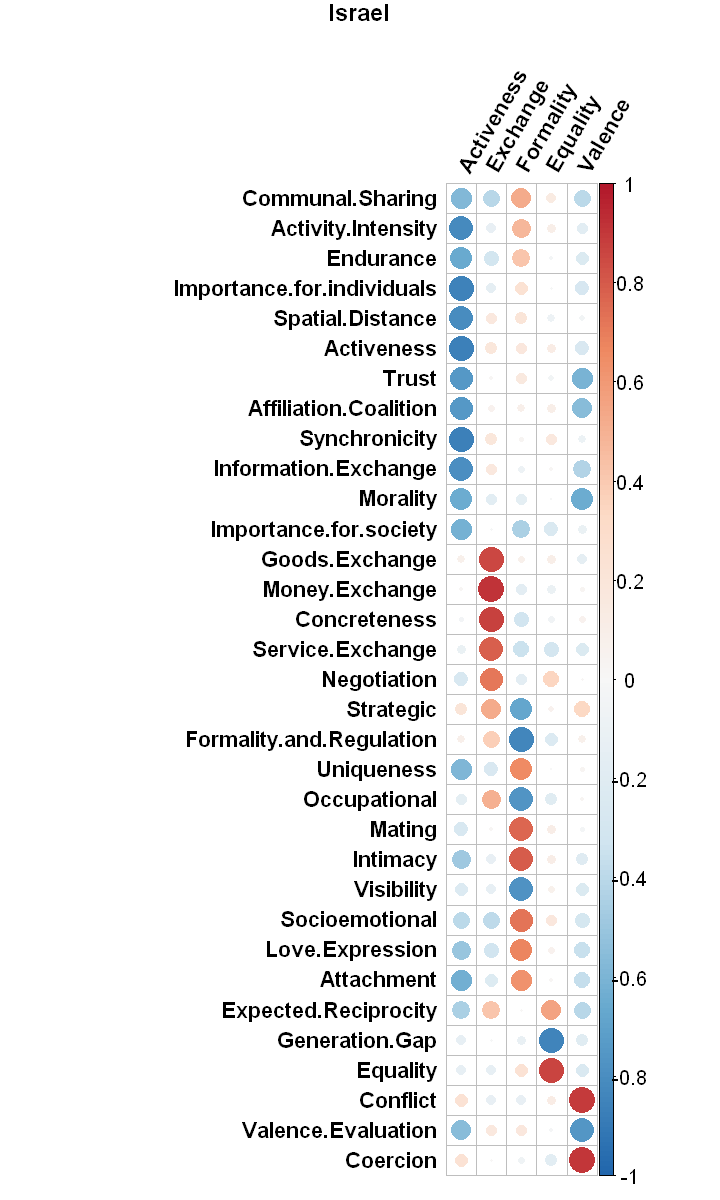

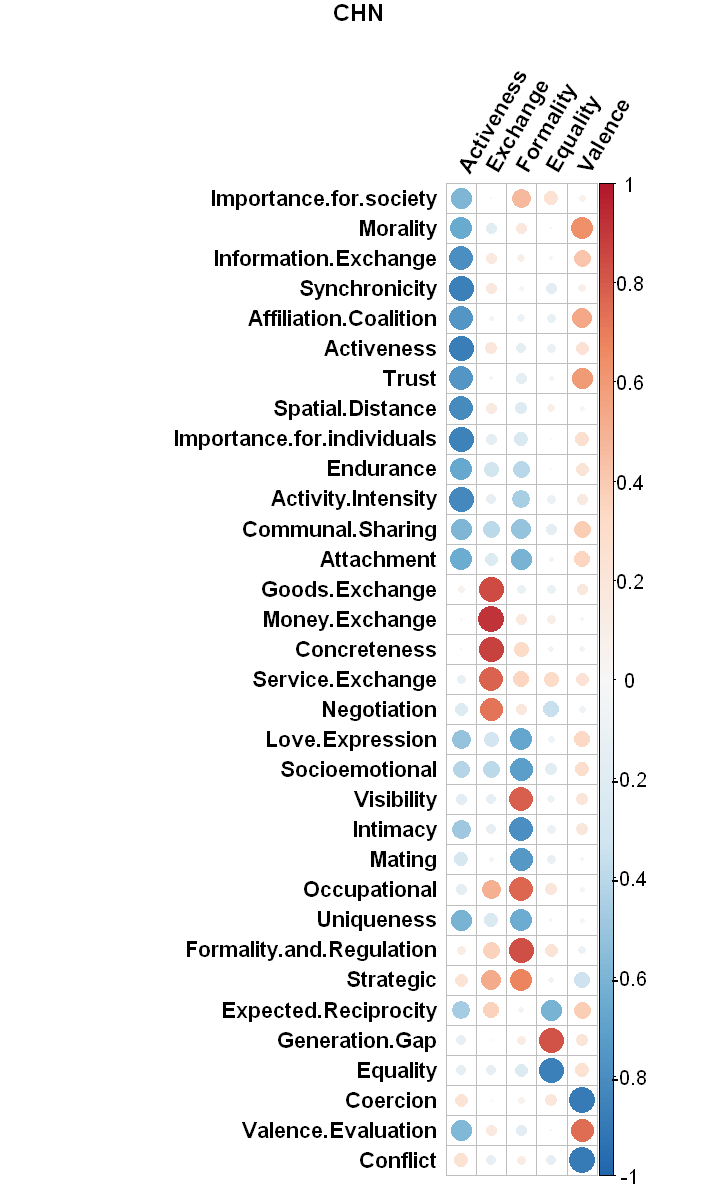

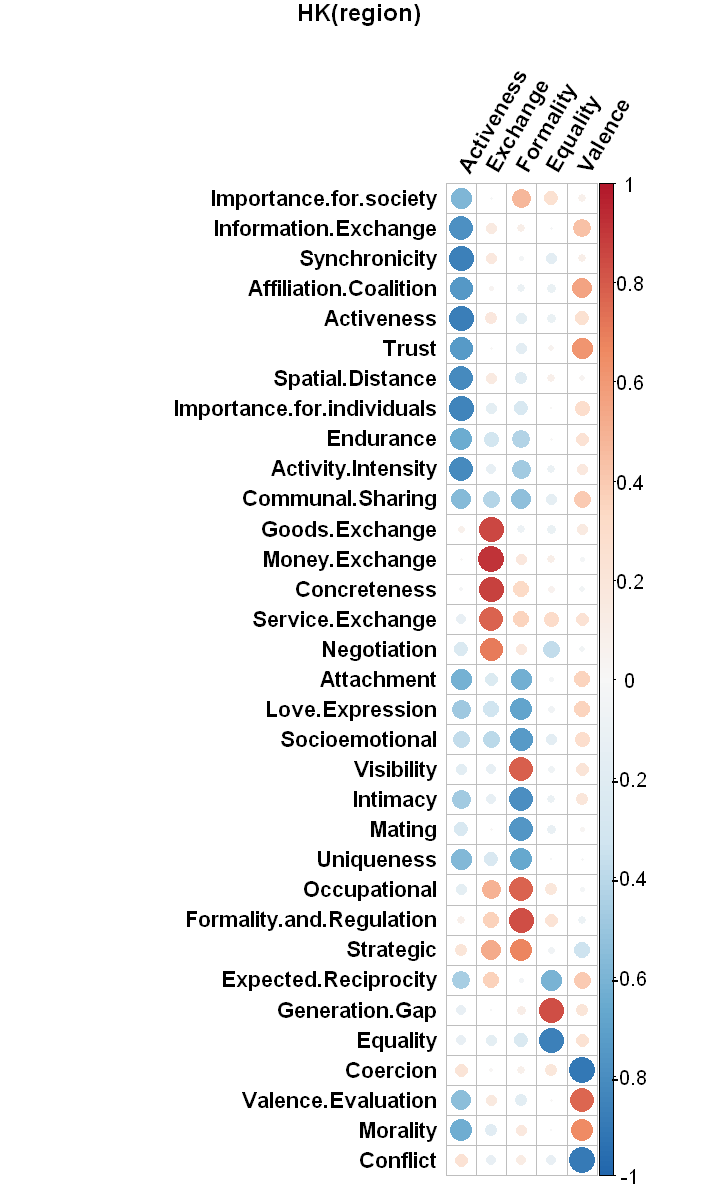

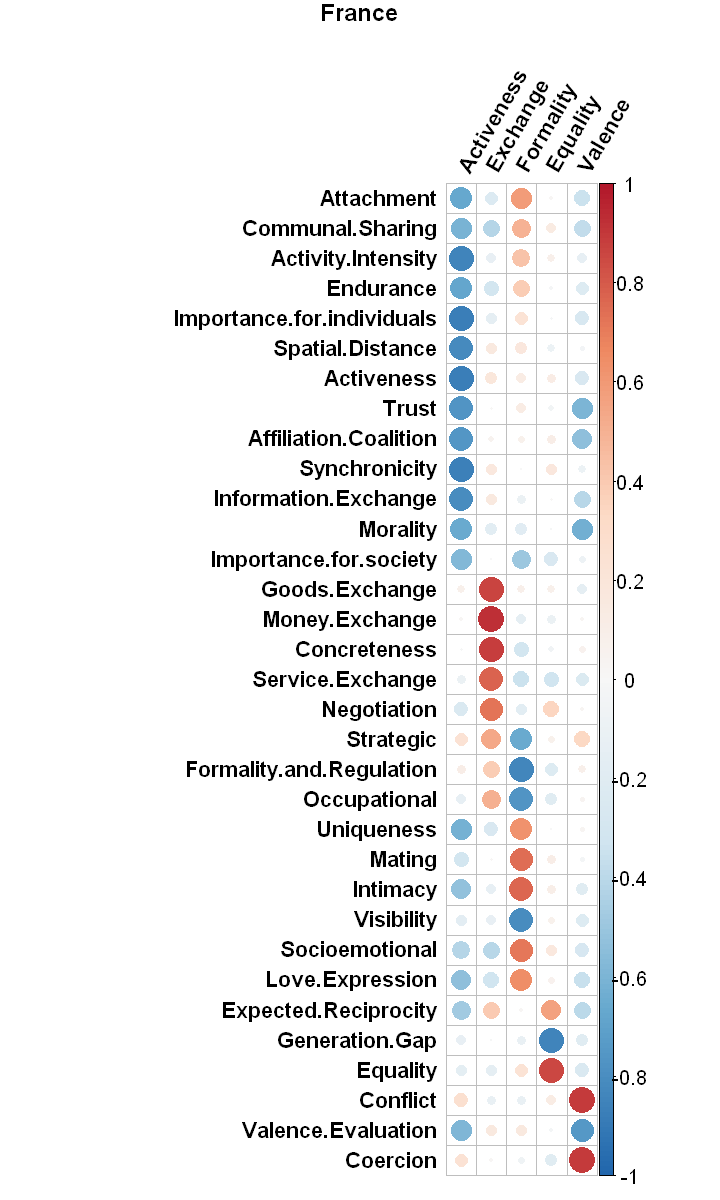

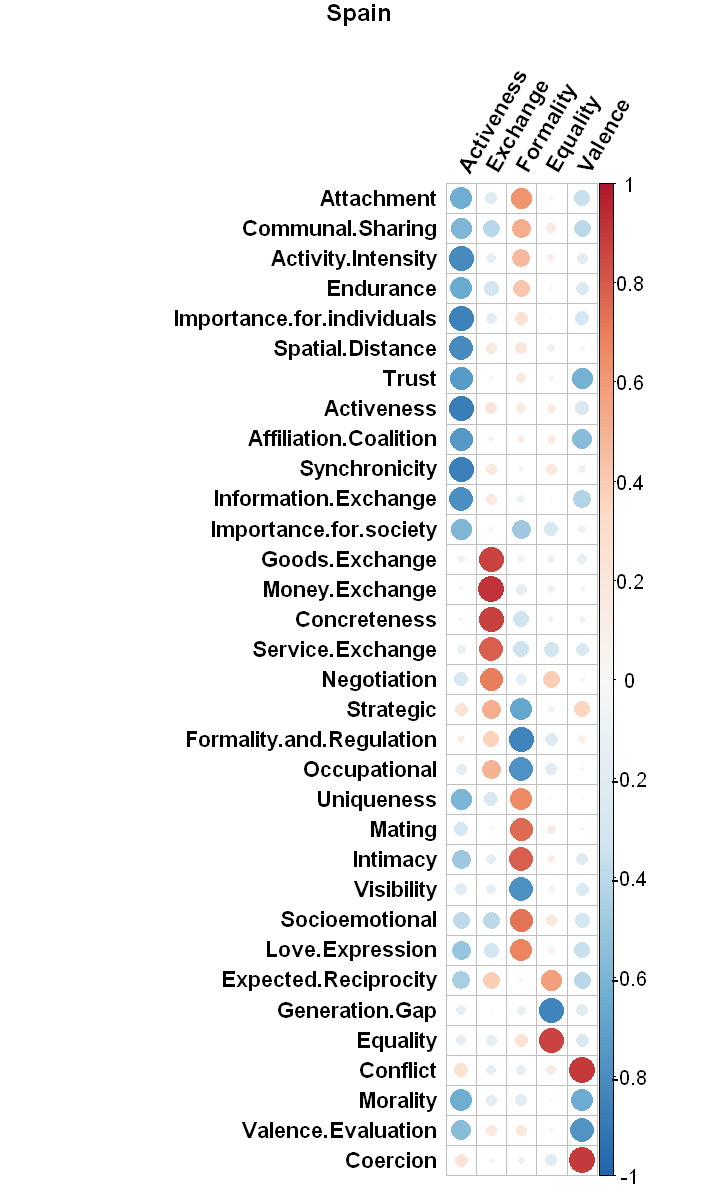

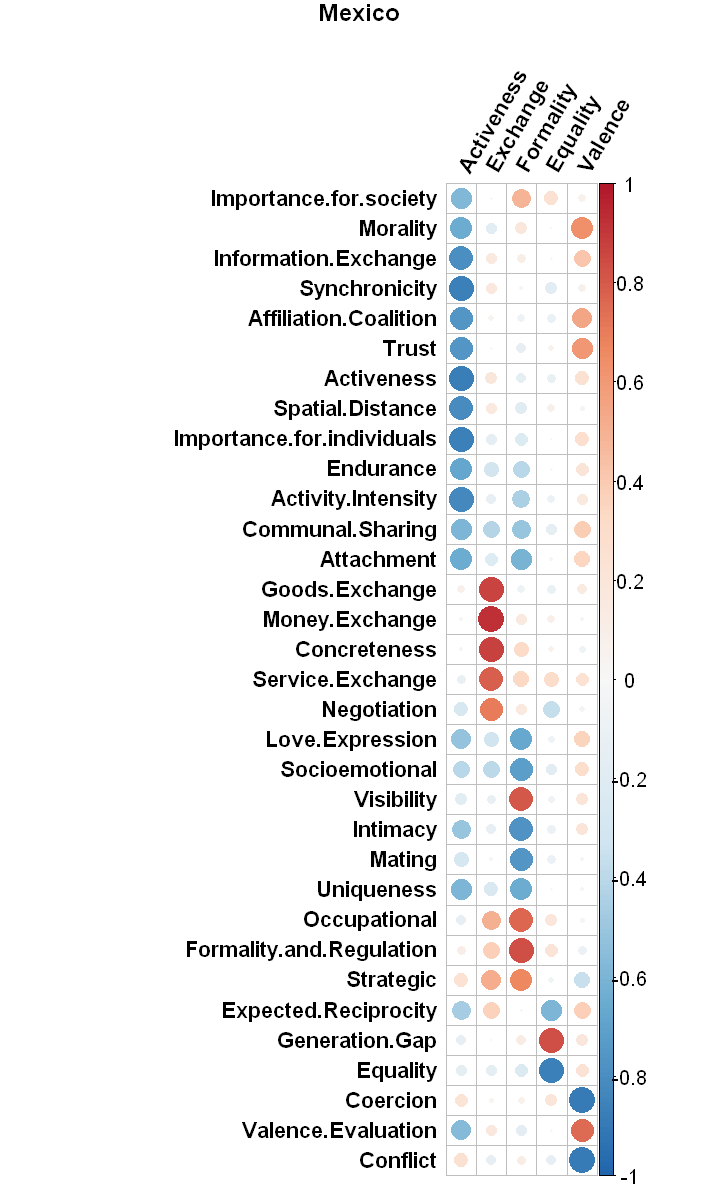

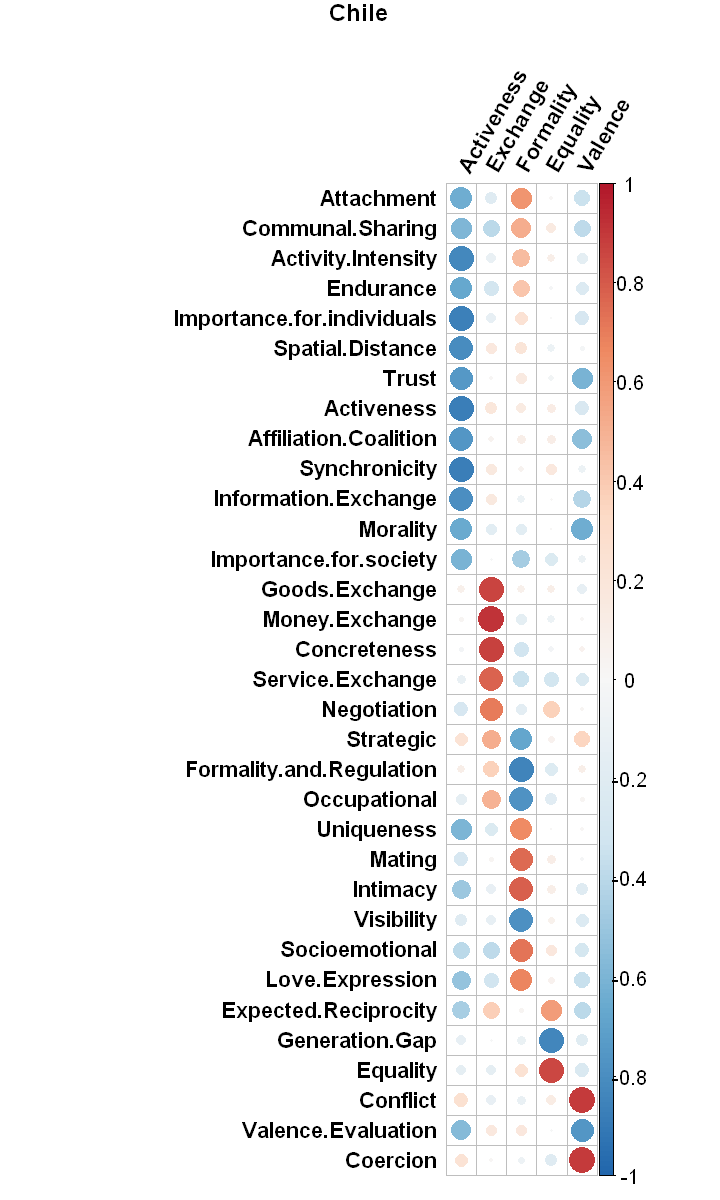

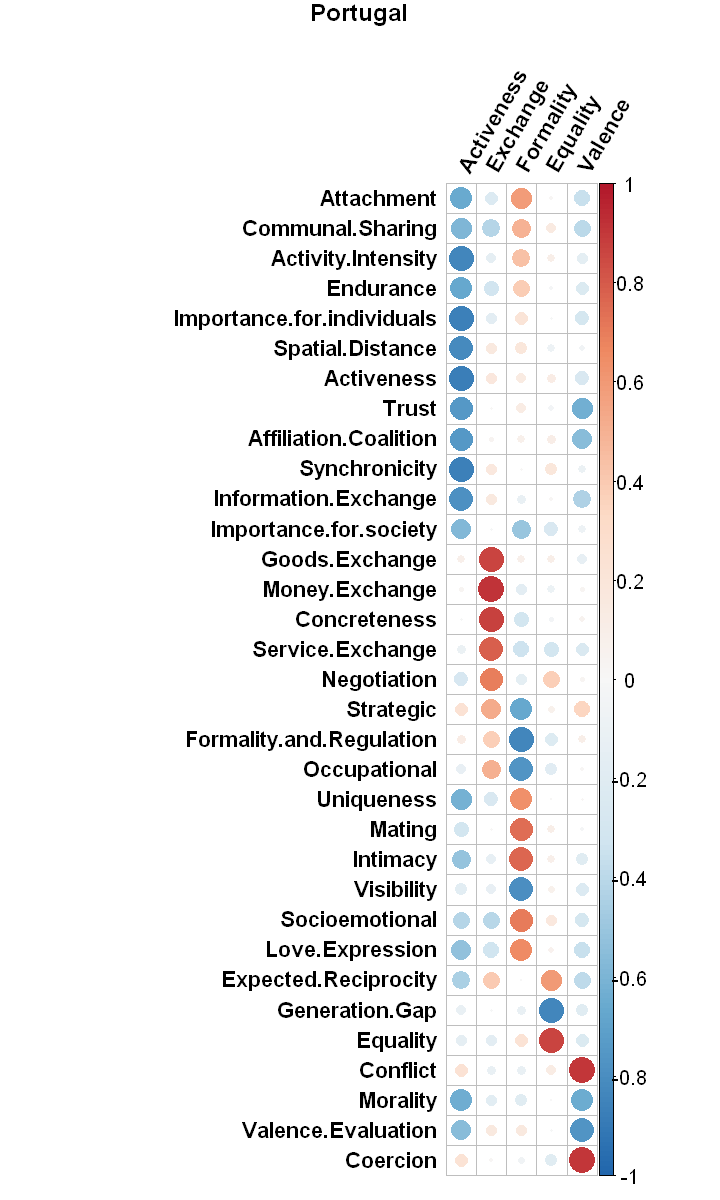

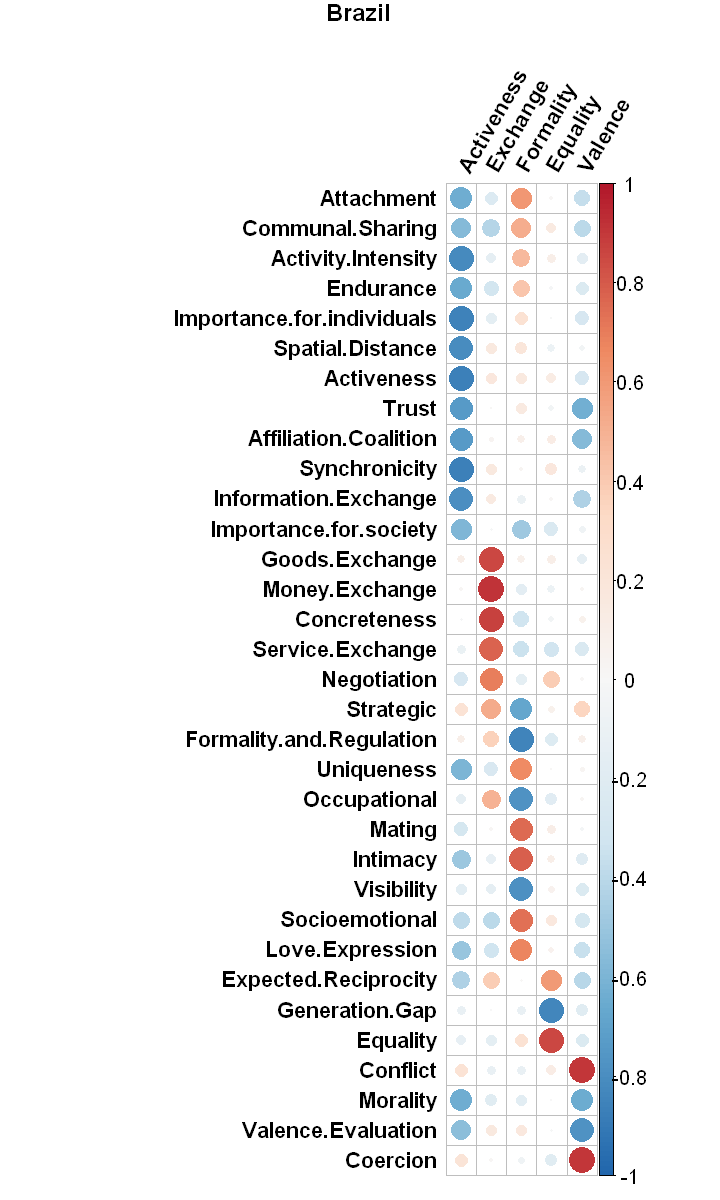

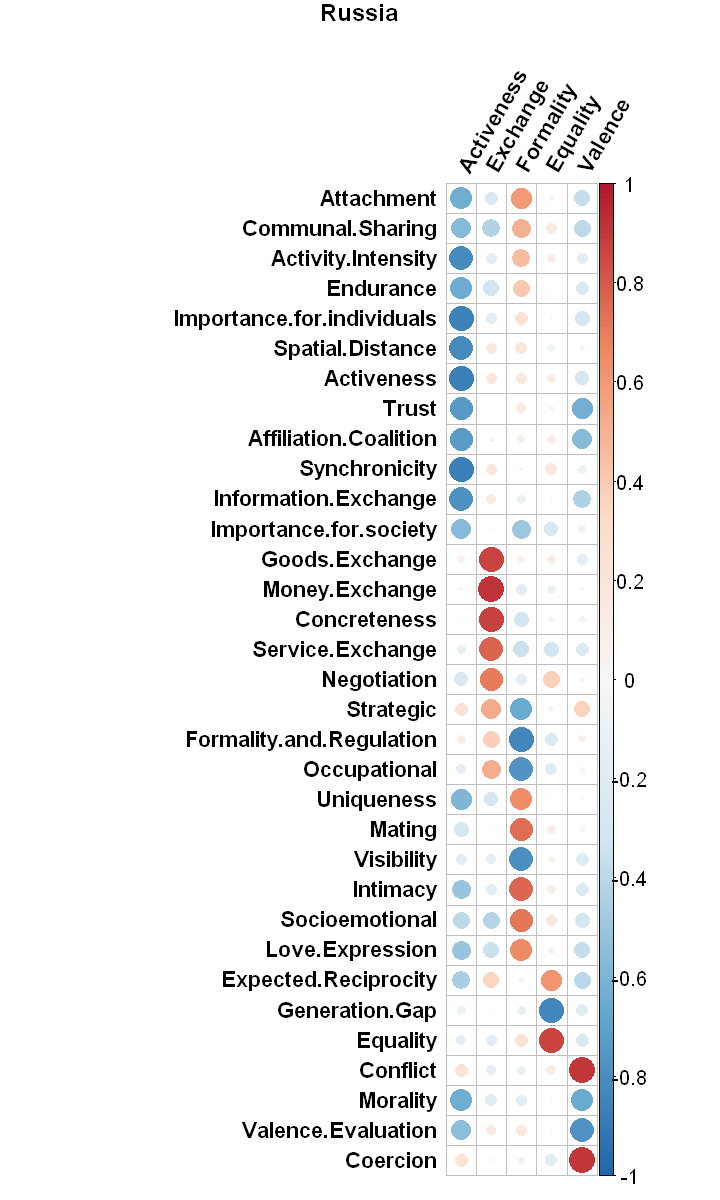

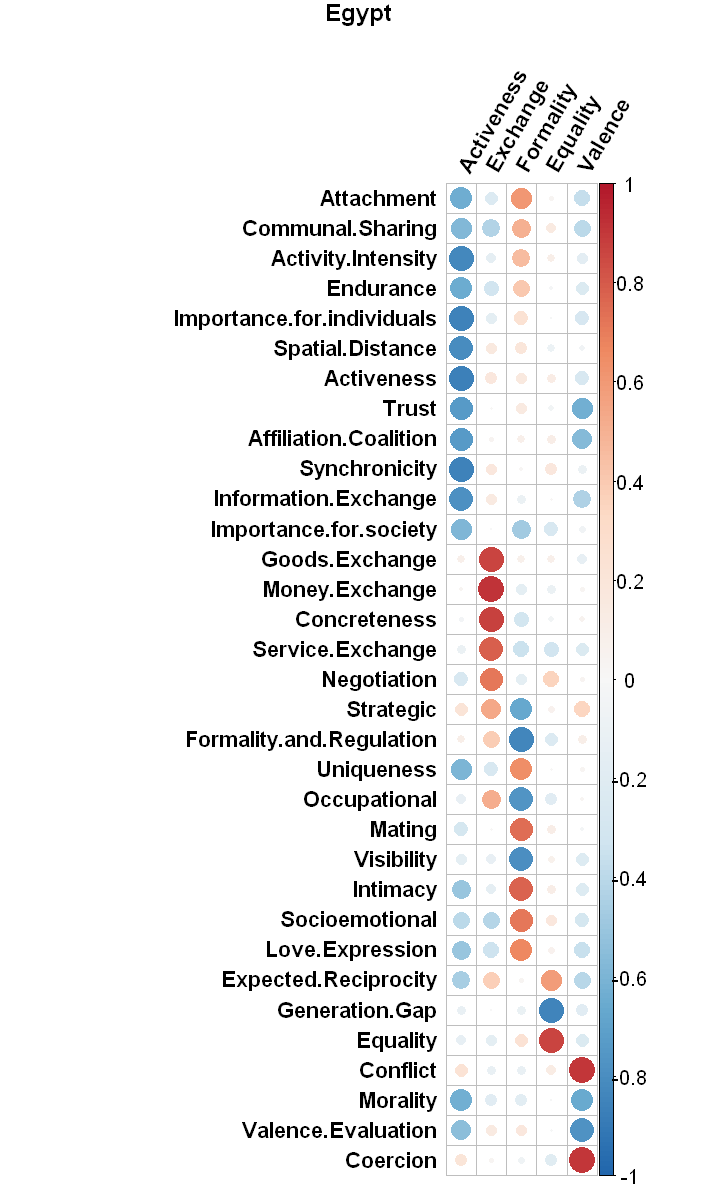

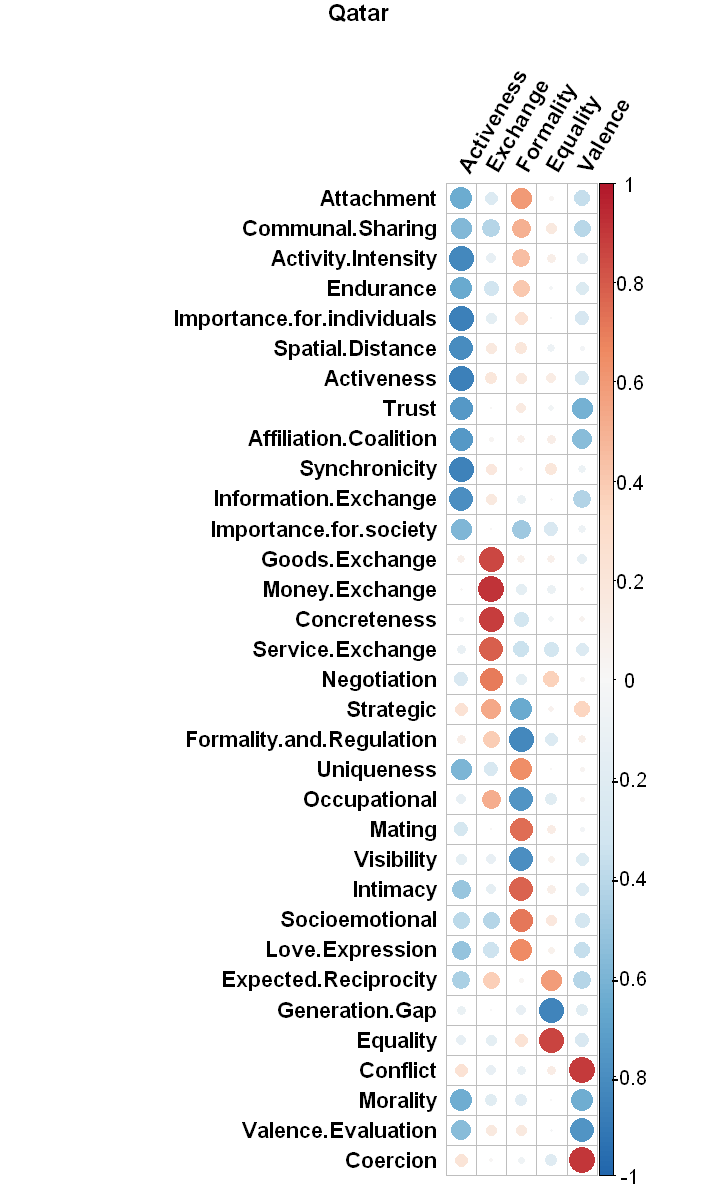

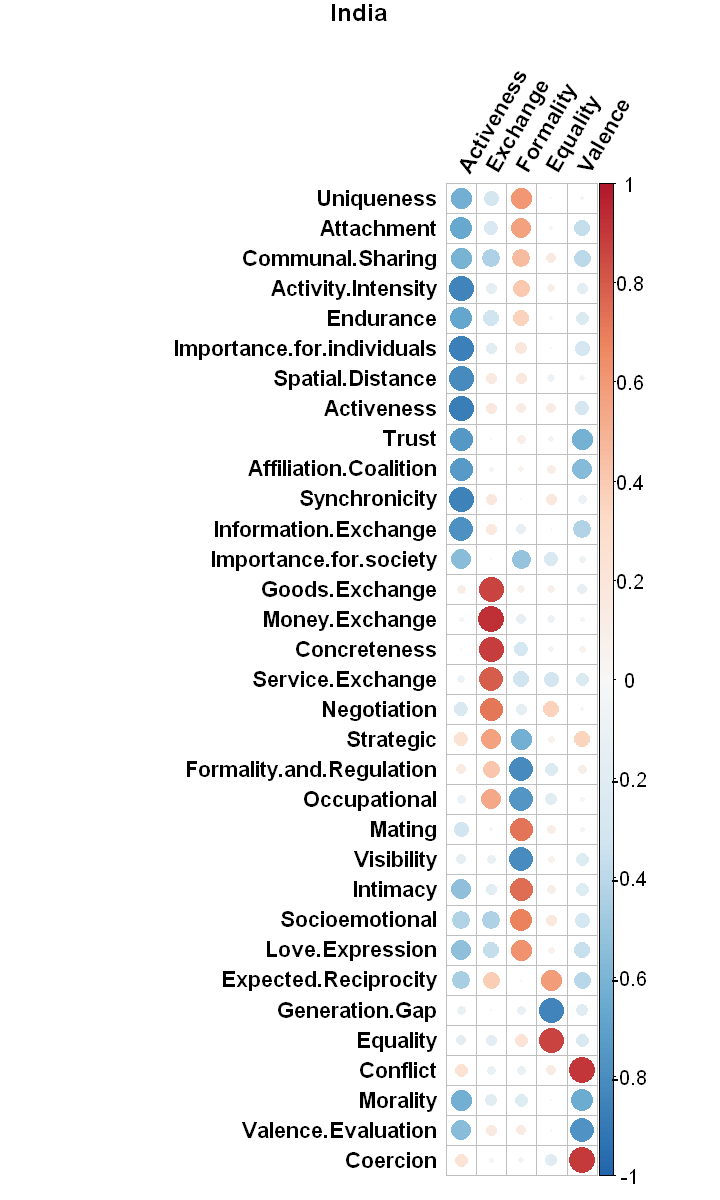

In [5]:
for (region in regions){
    averaged_world_loocv(region)
}

## assign label and fix the order

In [6]:
# summarise model labels
averaged_model_label_df = read.xlsx('input_data/dimensions_check.xlsx',
                           sheet='averaged_world_loocv')
averaged_model_label_df = rename(averaged_model_label_df,c('South Africa'='South.Africa'))
averaged_model_label_df = averaged_model_label_df[1:5,regions]
# transform dataframe into dictionary(list)
averaged_model_label_list = as.list(averaged_model_label_df)

averaged_model_label_name_list = list()
for (region in regions){
    total_file = paste('input_data/Nations/Total/averaged_world_loocv_favee/',region,'.csv',sep='')
    pca_5c_33d_scores_total = read.csv(total_file,row.names=1)
    
    # add model labal to raw models
    # grab the model labels
    model_label = averaged_model_label_list[[region]]
    reverse = rep(1,5)
    col_numbers = seq(1,5)
    count = 1
    for (label in model_label){
        # label of one dimension
        temp = strsplit(label,'(',fixed = TRUE)[[1]]
        model_label[count] = temp[1]

        if (!is.na(temp[2])){
            # whether the dimension required to be reversed or not
            reverse[count] = -1
        }

        count = count + 1
    }
    colnames(pca_5c_33d_scores_total) = model_label
    # reverse the column
    for (col in col_numbers){pca_5c_33d_scores_total[col] = pca_5c_33d_scores_total[col]*reverse[col]}
    averaged_model_label_name_list[[region]] = pca_5c_33d_scores_total
}

# Each model in 19 regions

In [7]:
file_path = 'output_data/pca_results/'

relationship_score_list = list()
for (region in dir(file_path)){
    file = paste(file_path,region,sep='')
    file = paste(paste(file,'/',sep=''),region,sep='')
    file = paste(file,'_scores_var_5c_33d.csv',sep='')
    favee_df = read.csv(file,row.names=1)
    
    region = gsub('HK','HK(region)',region) 
    region = gsub('South_africa','South Africa',region)
    relationship_score_list[[region]] = favee_df}

In [8]:
# summarise model labels
model_label_df = read.xlsx('input_data/dimensions_check.xlsx',
                           sheet='Model_33d_5c')
model_label_df = rename(model_label_df,c('South Africa'='South.Africa'))
model_label_df = model_label_df[1:5,regions]
# transform dataframe into dictionary(list)
model_label_list = as.list(model_label_df)

# add model labal to raw models
relationship_score_name_list = list()
for (region in names(model_label_list)){
    # grab the model labels
    model_label = model_label_list[[region]]
    reverse = rep(1,5)
    col_numbers = seq(1,5)
#     if (region %in% c('France','Mexico','Portugal')){
#         reverse = rep(1,4)
#         model_label = model_label[1:4]
#         col_numbers = seq(1,4)
#     }
    count = 1
    for (label in model_label){
        # label of one dimension
        temp = strsplit(label,'(',fixed = TRUE)[[1]]
        model_label[count] = temp[1]
        
        if (!is.na(temp[2])){
            # whether the dimension required to be reversed or not
            reverse[count] = -1
        }
        
        count = count + 1
    }
    region_df = relationship_score_list[[region]]
    colnames(region_df) = model_label
    # reverse the column
    for (col in col_numbers){region_df[col] = region_df[col]*reverse[col]}
    relationship_score_name_list[[region]] = region_df
    
    print(region)
    print(reverse)
}

[1] "USA"
[1] -1  1 -1  1  1
[1] "UK"
[1]  1 -1 -1 -1  1
[1] "Australia"
[1]  1  1 -1  1  1
[1] "South Africa"
[1] -1  1  1 -1 -1
[1] "Germany"
[1]  1  1 -1 -1  1
[1] "Japan"
[1] -1  1  1 -1  1
[1] "Israel"
[1] -1  1 -1 -1  1
[1] "CHN"
[1] -1  1  1  1 -1
[1] "HK(region)"
[1] -1  1  1  1  1
[1] "France"
[1]  1 -1 -1  1  1
[1] "Spain"
[1] -1  1 -1  1  1
[1] "Mexico"
[1] -1  1  1  1 -1
[1] "Chile"
[1] 1 1 1 1 1
[1] "Portugal"
[1]  1  1  1 -1 -1
[1] "Brazil"
[1] -1  1  1 -1 -1
[1] "Russia"
[1] -1 -1 -1 -1 -1
[1] "Egypt"
[1] -1  1 -1 -1 -1
[1] "Qatar"
[1] -1  1  1  1 -1
[1] "India"
[1]  1  1 -1 -1  1


In [9]:
# Adjust the order of dimensions to be consistent FAVEE
FAVEE = c('Formality','Activeness','Valence','Exchange','Equality')
relationship_FAVEE_list = list()
for (region in names(relationship_score_name_list)){
    temp_df = relationship_score_name_list[[region]]
    if (region %in% c('USA','UK','South Africa','Australia','Germany',
                      'CHN','HK(region)','Israel','Brazil','Japan','Spain',
                      'France','Mexico','Portugal','Chile'))
    {temp_df = temp_df[,FAVEE]}


    else if (region %in% c('Russia','Egypt','Qatar','India'))
    {temp_df = temp_df[,c('Formality','Activeness','Valence','Exchange','Socioemotional')]}
    relationship_FAVEE_list[[region]] = temp_df
}

# Correlation of each region and averaged regions in each dimension(leave one out)

In [10]:
dimension_region_list = {}
for (region in regions){
    # caculate correlation of each region's 5 dimensions and the average total model
    region_df = relationship_FAVEE_list[region]
    pca_5c_33d_scores_total = averaged_model_label_name_list[[region]]
    pca_5c_33d_scores_total = pca_5c_33d_scores_total[,
                            c('Formality','Activeness','Valence','Exchange','Equality')]

    region_total = cbind(region_df,pca_5c_33d_scores_total)
    region_total_cor = cor(region_total, method='spearman')
    region_total_cor = region_total_cor[6:10,1:5]
    
    # contain resutls in dictionary
    dimension_region_list[[region]] = region_total_cor
}

# Plot results

In [11]:
options (warn = -1) # remove warning
all_results_df = data.frame()
for (region in names(dimension_region_list)){
    region_df = dimension_region_list[[region]]
    # unify the labels in x axis
    colnames(region_df) = paste('RC',seq(1,5),sep='')

    region_df = melt(region_df) %>% rename('total'='X1','region'='X2')
    region_df['region_label'] = region
    
    all_results_df = rbind(all_results_df,region_df)
}
all_results_df$region_label = factor(all_results_df$region_label,
levels = c('Australia','Brazil','CHN','Chile','France','Germany','HK(region)',
           'Israel','Japan','Mexico','Portugal',
           'South Africa','Spain','UK','USA',

           'Egypt','India','Qatar','Russia'
           ))
head(all_results_df,3)

,total,region,value,region_label
,<fct>,<fct>,<dbl>,<fct>
1,Formality,RC1,0.87464772,USA
2,Activeness,RC1,-0.07495223,USA
3,Valence,RC1,-0.20230774,USA


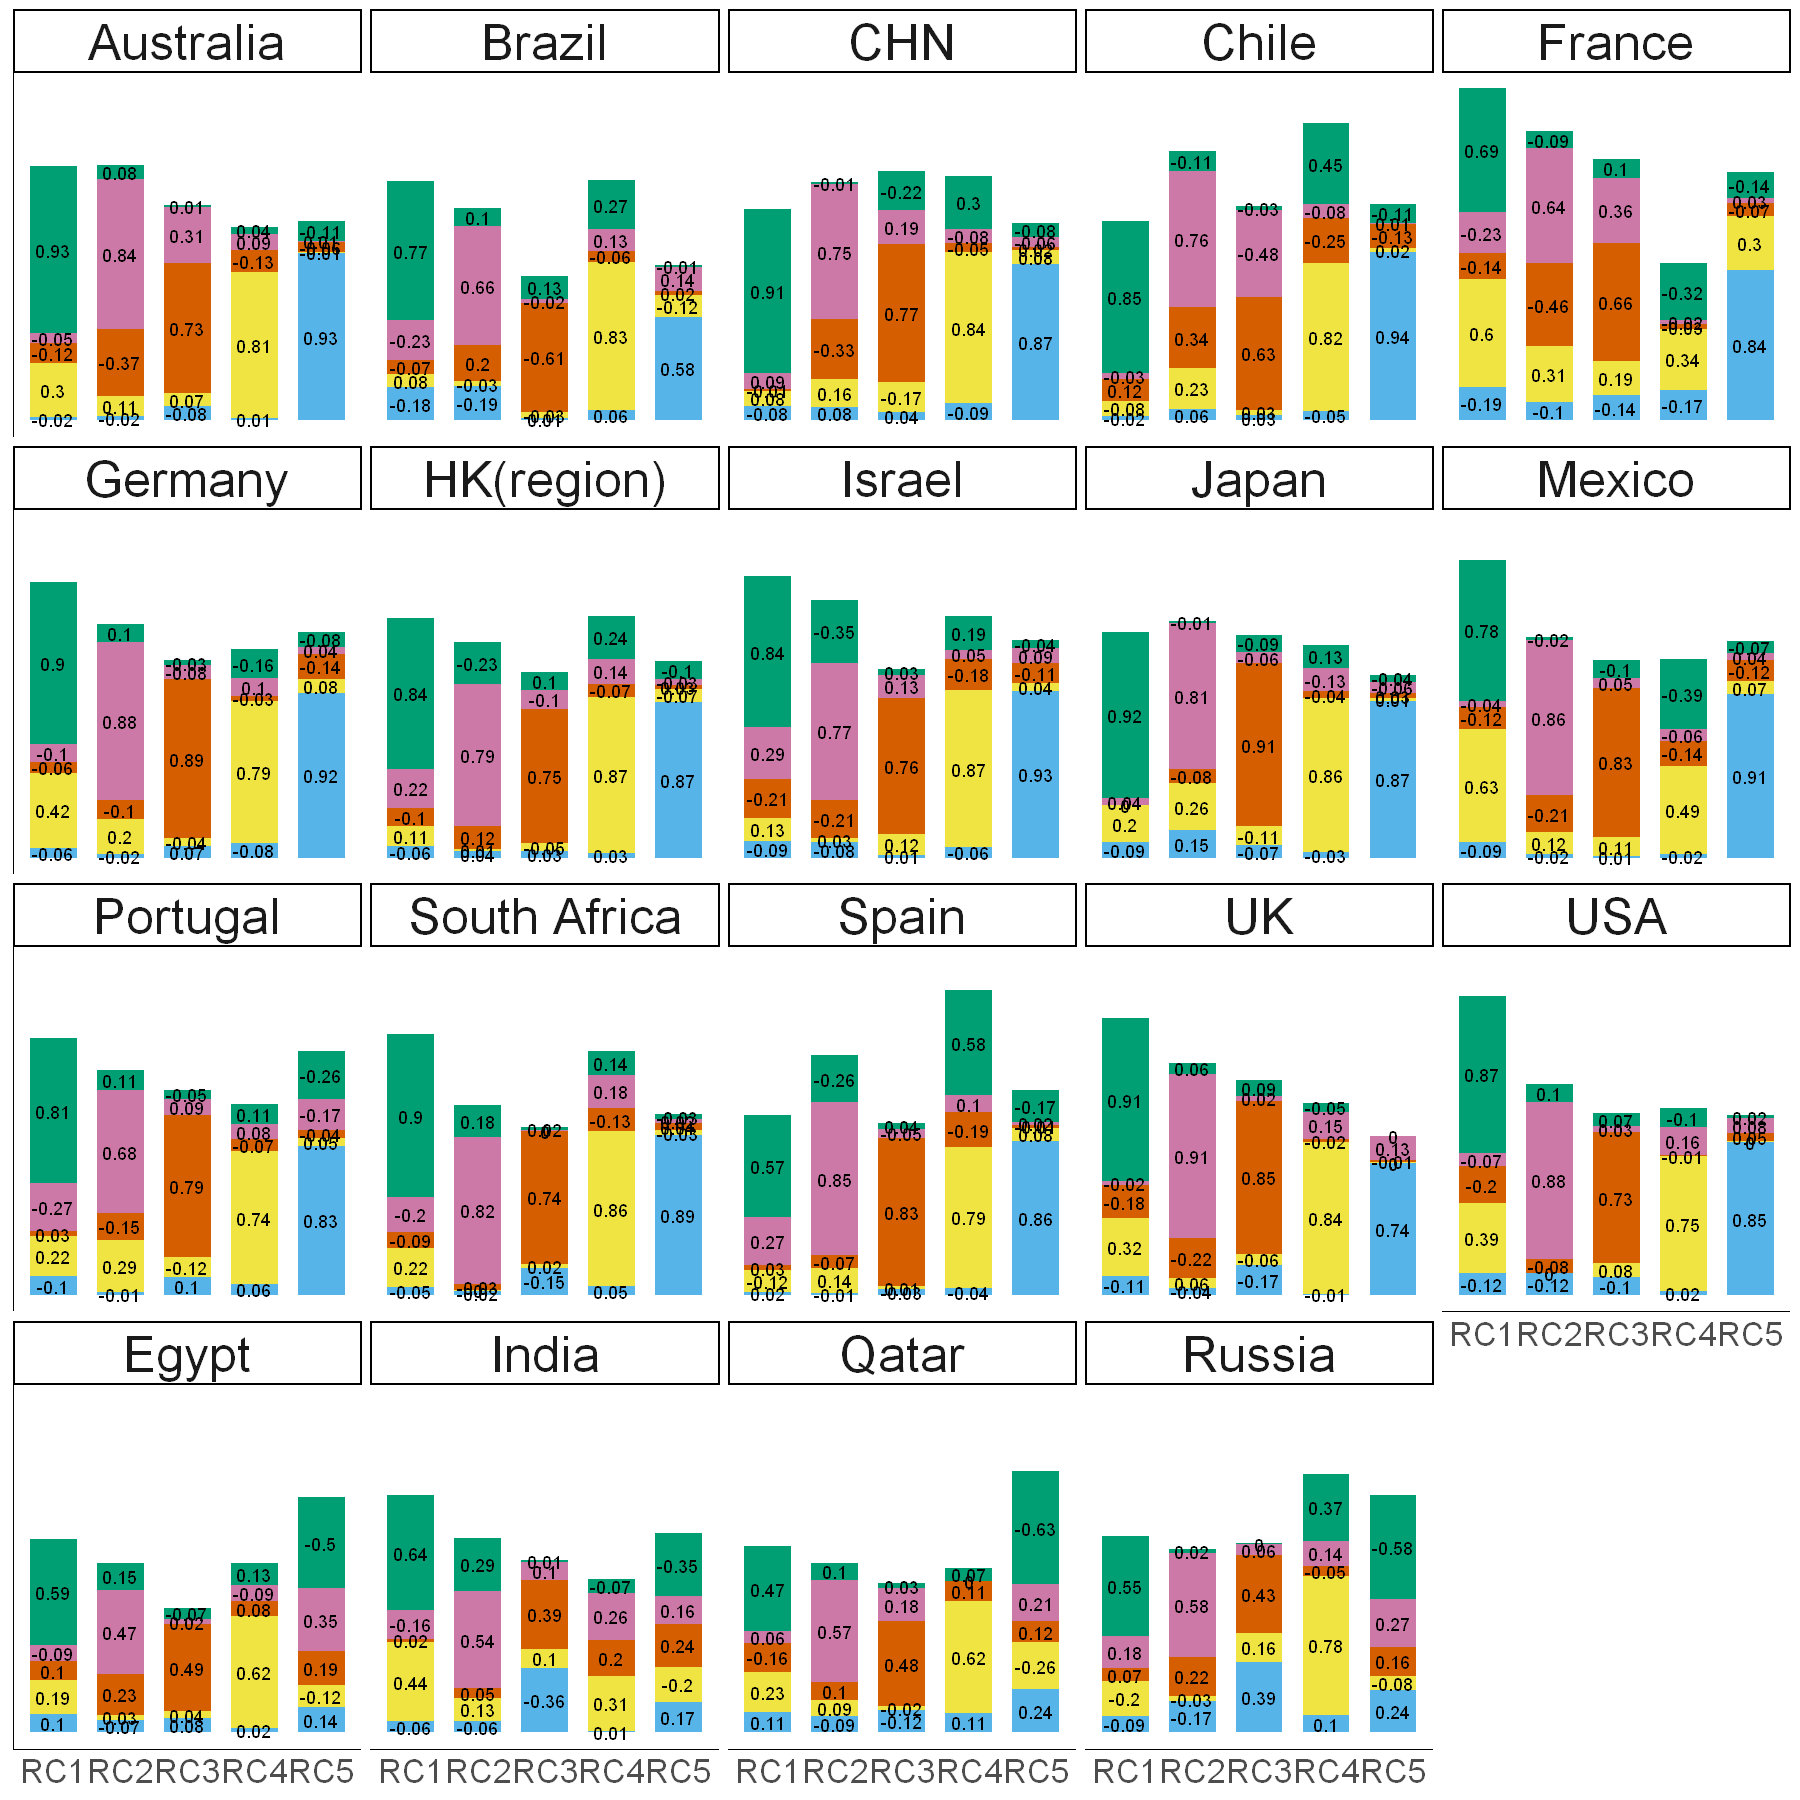

In [12]:
options(repr.plot.width=15,repr.plot.height=15)
all_results_df  %>%
ggplot(aes(x=region,y=abs(value),fill=total))+
geom_bar(stat='identity', width=0.7)+
facet_wrap(region_label~.,ncol=5)+
geom_text(aes(label=round(value,2)),position=position_stack(vjust=0.5))+
scale_fill_manual(values=c('Formality'='#009E73','Activeness'='#CC79A7',
                           'Valence'='#D55E00','Exchange'='#F0E442','Equality'='#56B4E9'))+
theme_classic()+
theme(legend.position='none',
      axis.text.x = element_text(size=20),
      axis.text.y = element_blank(),axis.ticks = element_blank(),
      strip.text = element_text(size=30),
      axis.title = element_blank())

In [13]:
plot_line = function(regions){
    options(repr.plot.width=15,repr.plot.height=3.3)
    all_results_df %>% filter(region_label %in% regions) %>%
    ggplot(aes(x=region,y=abs(value),fill=total))+
    geom_bar(stat='identity', width=0.7)+
    facet_grid(.~region_label,switch = 'x')+
    geom_text(aes(label=round(value,2)),position=position_stack(vjust=0.5))+
    scale_fill_manual(values=c('Formality'='#009E73','Activeness'='#CC79A7',
                               'Valence'='#D55E00','Exchange'='#F0E442','Equality'='#56B4E9'))+
    theme_classic()+
    theme(legend.position='none',
          #axis.text.x = element_text(size=20),
          axis.line = element_line(colour = "white"),
          strip.background = element_rect(color='white',fill='#767171'),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),axis.ticks = element_blank(),
          strip.text = element_text(size=26,color='white'),
          axis.title = element_blank(),
          panel.spacing = unit(2,"lines"))
}
plot_last_line = function(regions){
    options(repr.plot.width=12,repr.plot.height=3.3)
    all_results_df %>% filter(region_label %in% regions) %>%
    ggplot(aes(x=region,y=abs(value),fill=total))+
    geom_bar(stat='identity', width=0.7)+
    facet_grid(.~region_label,switch = 'x')+
    geom_text(aes(label=round(value,2)),position=position_stack(vjust=0.5))+
    scale_fill_manual(values=c('Formality'='#009E73','Activeness'='#CC79A7',
                               'Valence'='#D55E00','Exchange'='#F0E442','Equality'='#56B4E9'))+
    theme_classic()+
    theme(legend.position='none',
          #axis.text.x = element_text(size=20),
          axis.line = element_line(colour = "white"),
          strip.background = element_rect(color='white',fill='#767171'),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),axis.ticks = element_blank(),
          strip.text = element_text(size=26,color='white'),
          axis.title = element_blank(),
          panel.spacing = unit(2,"lines"))
}

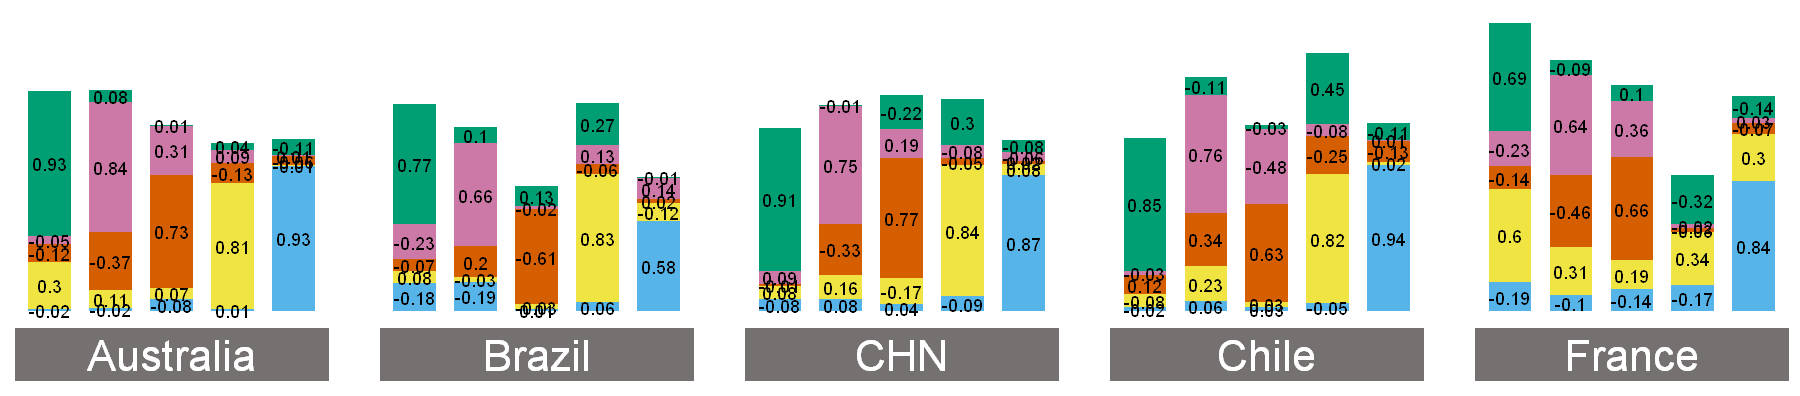

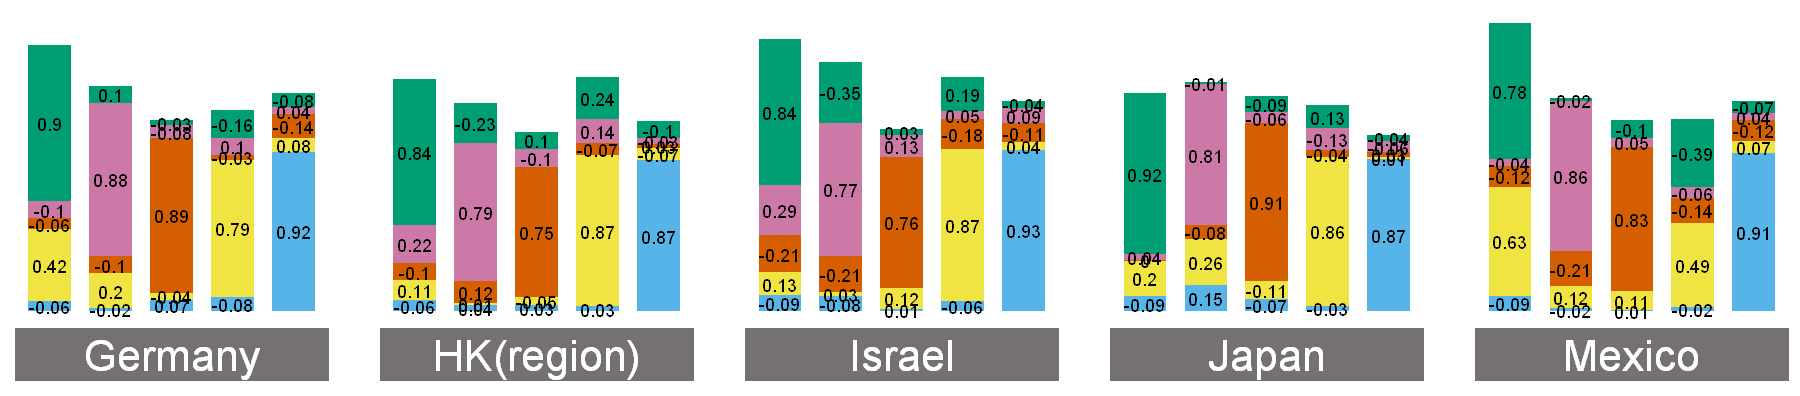

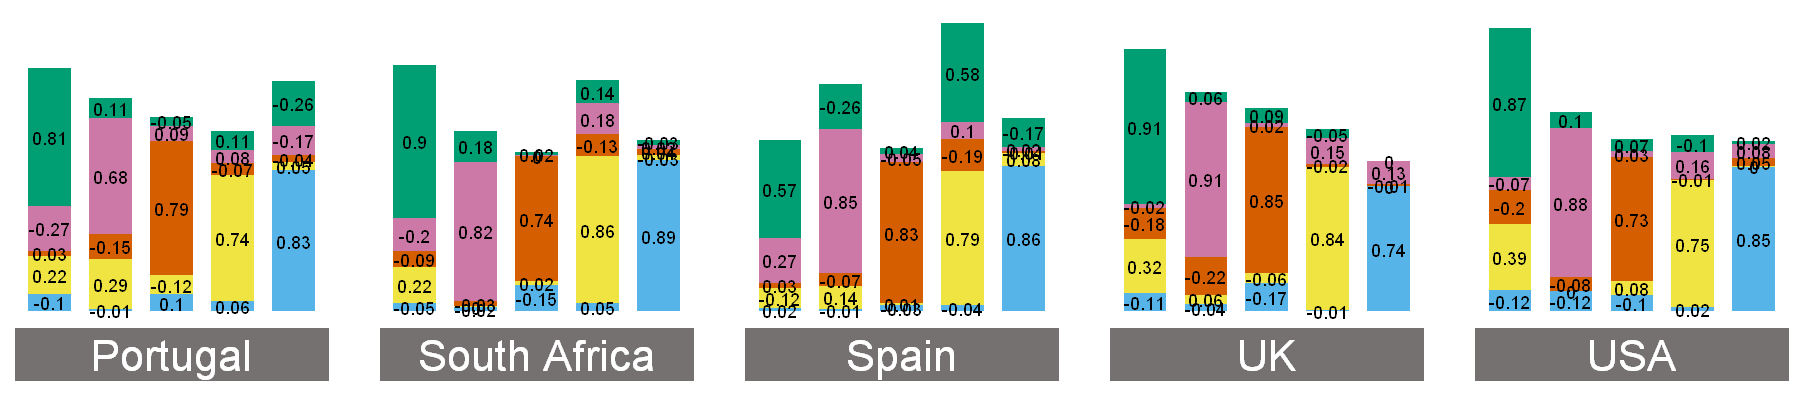

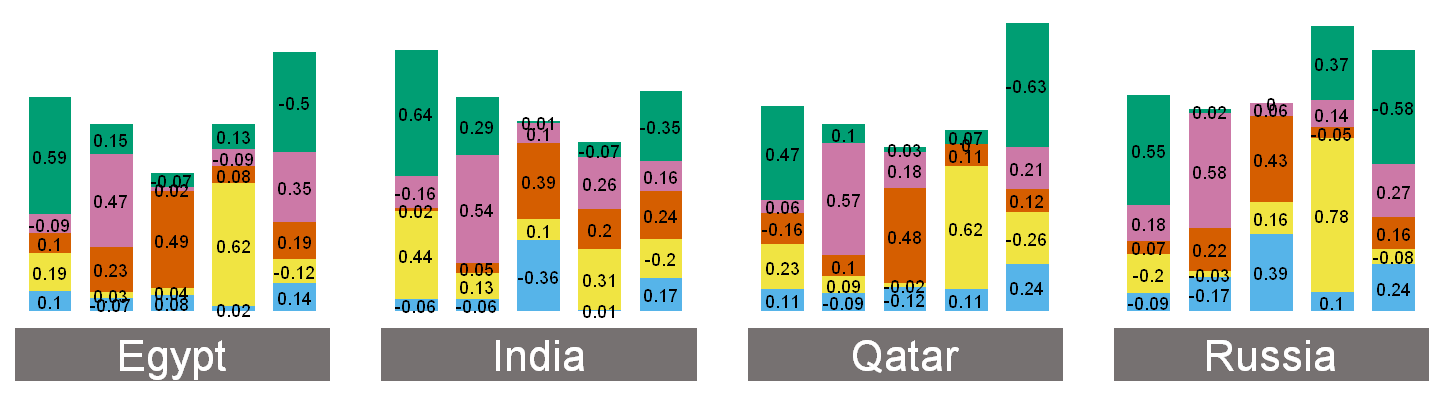

In [14]:
plot_line(c('Australia','Brazil','CHN','Chile','France'))
plot_line(c('Germany','HK(region)','Israel','Japan','Mexico'))
plot_line(c('Portugal','South Africa','Spain','UK','USA'))
plot_last_line(c('Egypt','India','Qatar','Russia'))

In [15]:
png("../output_graph/world_averaged/MeaningOf33D/1.png", bg="transparent",
    family = 'sans',units='in',width=15,height=3.3,res=300)
plot_line(c('Australia','Brazil','CHN','Chile','France'))
dev.off()

png("../output_graph/world_averaged/MeaningOf33D/2.png", bg="transparent",
    family = 'sans',units='in',width=15,height=3.3,res=300)
plot_line(c('Germany','HK(region)','Israel','Japan','Mexico'))
dev.off()

png("../output_graph/world_averaged/MeaningOf33D/3.png", bg="transparent",
    family = 'sans',units='in',width=15,height=3.3,res=300)
plot_line(c('Portugal','South Africa','Spain','UK','USA'))
dev.off()

png("../output_graph/world_averaged/MeaningOf33D/4.png", bg="transparent",
    family = 'sans',units='in',width=12,height=3.3,res=300)
plot_last_line(c('Egypt','India','Qatar','Russia'))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2